# FEATURES

In [38]:
#Importing relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

## First, we examine the text in the dataset, to get a more detailed understanding of the dataset

### Average word length

In [2]:
avg_word_length_df=pd.read_csv('text_dataset.csv')
def average_word_length(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

# Apply the function to calculate average word length
avg_word_length_df['average_word_length'] = avg_word_length_df['cleaned_text'].apply(average_word_length)
avg_word_length_df

,label,cleaned_text,cleaned_subject,cleaned_title,token_count,average_word_length
0,1,donald trump met member nato go well moment ar...,news,watch trump shove foreign leader way get front...,71,6.490826
1,0,washington reuters rick perry presidentelect d...,politicsnews,trump energy pick perry softens stance climate...,128,6.385744
2,1,president obama blasted republican presidentia...,politics,obama finally build border wallbut there one p...,81,6.072961
3,1,male idaho republican five daughter made creep...,news,republican lawmaker say rape wont cause pregna...,82,6.469388
4,1,kellyanne conway tried spin white house press ...,news,watch chuck todd swat annoying kellyanne conwa...,75,6.296496
...,...,...,...,...,...,...
13829,0,washington reuters member u congress party fri...,politicsnews,u lawmaker back syria strike demand plan trump,107,6.514512
13830,1,far video 530000 view make content legitimate ...,politics,ups secretly fly refugee u middle east watch g...,110,6.782524
13831,0,dec 27 story corrects say 55000 page email ins...,politicsnews,u appeal court revives clinton email suit,82,6.117021
13832,0,madrid reuters spain high court said tuesday g...,worldnews,spanish court grant u extradition russian hack...,75,6.478632


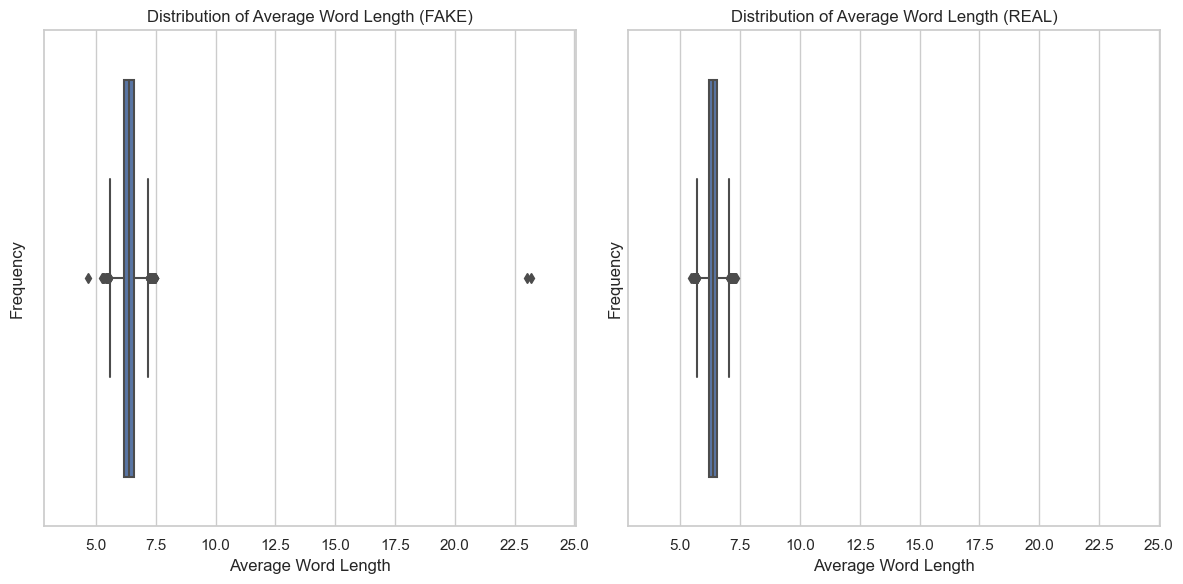

In [3]:
min_length = avg_word_length_df['average_word_length'].min()
max_length = avg_word_length_df['average_word_length'].max()

# Optionally, add a buffer around the range to ensure all data points are clearly visible
buffer = (max_length - min_length) * 0.1
x_min = min_length - buffer
x_max = max_length + buffer

# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Create a figure with two subplots (axes)
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Boxplot for entries with label=1
sns.boxplot(x=avg_word_length_df[avg_word_length_df['label'] == 1]['average_word_length'], ax=axes[0])
axes[0].set_title('Distribution of Average Word Length (FAKE)')
axes[0].set_xlabel('Average Word Length')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim([x_min, x_max])  # Set common x-axis range

# Boxplot for entries with label=0
sns.boxplot(x=avg_word_length_df[avg_word_length_df['label'] == 0]['average_word_length'], ax=axes[1])
axes[1].set_title('Distribution of Average Word Length (REAL)')
axes[1].set_xlabel('Average Word Length')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim([x_min, x_max])  # Set common x-axis range

# Display the plots
plt.tight_layout()
plt.show()

### TF-IDF 

We want to examine whether some words are more important than others, in determining whether it is fake or real news, which will be done by using TF-IDF.

In [4]:
df = pd.read_csv('text_dataset.csv')

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Apply TF-IDF to the 'cleaned_text' column and create the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [5]:
# Convert the TF-IDF matrix to a DataFrame for easier manipulation
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [6]:
# Display the first few rows of the DataFrame
print(tfidf_df.head())

    00  000  0000  000000017  000004  00009  0001  000270ks  0006  0009  ...  \
0  0.0  0.0   0.0        0.0     0.0    0.0   0.0       0.0   0.0   0.0  ...   
1  0.0  0.0   0.0        0.0     0.0    0.0   0.0       0.0   0.0   0.0  ...   
2  0.0  0.0   0.0        0.0     0.0    0.0   0.0       0.0   0.0   0.0  ...   
3  0.0  0.0   0.0        0.0     0.0    0.0   0.0       0.0   0.0   0.0  ...   
4  0.0  0.0   0.0        0.0     0.0    0.0   0.0       0.0   0.0   0.0  ...   

   zynga  zypries  zyries  zyuganov  zyuseragentifzxzbreak   zz  zztaine  \
0    0.0      0.0     0.0       0.0                    0.0  0.0      0.0   
1    0.0      0.0     0.0       0.0                    0.0  0.0      0.0   
2    0.0      0.0     0.0       0.0                    0.0  0.0      0.0   
3    0.0      0.0     0.0       0.0                    0.0  0.0      0.0   
4    0.0      0.0     0.0       0.0                    0.0  0.0      0.0   

   zzzzaaaacccchhh  zzzzzzzzzzzzz  émigré  
0              0.0

Now we look into the importance of different words in the dataset.
We look at what words are the most important for fake news and real news.

In [7]:
# Filter DataFrame for real news (label 0)
real_news_df = df[df['label'] == 0]

# Filter DataFrame for fake news (label 1)
fake_news_df = df[df['label'] == 1]

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Apply TF-IDF to the 'cleaned_text' column of real news
tfidf_matrix_real = tfidf_vectorizer.fit_transform(real_news_df['cleaned_text'])

# Convert TF-IDF matrix to DataFrame for real news
tfidf_df_real = pd.DataFrame(tfidf_matrix_real.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Apply TF-IDF to the 'cleaned_text' column of fake news
tfidf_matrix_fake = tfidf_vectorizer.fit_transform(fake_news_df['cleaned_text'])

# Convert TF-IDF matrix to DataFrame for fake news
tfidf_df_fake = pd.DataFrame(tfidf_matrix_fake.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Identify the most important words based on their TF-IDF scores for real news
top_words_real = tfidf_df_real.max().sort_values(ascending=False)

# Identify the most important words based on their TF-IDF scores for fake news
top_words_fake = tfidf_df_fake.max().sort_values(ascending=False)

# Display the top N most important words for real news
N = 10  # You can change this value to display more or fewer words
print("Top", N, "Most Important Words for Real News:")
print(top_words_real.head(N))

# Display the top N most important words for fake news
print("\nTop", N, "Most Important Words for Fake News:")
print(top_words_fake.head(N))

Top 10 Most Important Words for Real News:
moreno      0.855097
mica        0.851599
fed         0.830846
taiwan      0.824742
wray        0.817507
pakistan    0.804269
lotte       0.802948
thiel       0.798879
dowd        0.798361
morneau     0.798314
dtype: float64

Top 10 Most Important Words for Fake News:
phoenixnewtimes    0.905110
scotusblog         0.895832
petrov             0.870686
popick             0.869683
pavarotti          0.860920
schlafly           0.843167
schiller           0.816615
dao                0.808910
silverman          0.803492
sabo               0.802741
dtype: float64


## Secondly, we examine the dataset more in depth and create relevant features to explore the data further

### SENTIMENT ANALYSIS

In [41]:
sentiment_df = pd.read_csv('text_dataset.csv')

In [43]:
# Function to apply sentiment analysis
def analyze_sentiment(text):
    testimonial = TextBlob(text)
    return testimonial.sentiment.polarity, testimonial.sentiment.subjectivity

# Applying sentiment analysis to the 'cleaned_text' and 'cleaned_title' columns
sentiment_df['text_polarity'], sentiment_df['text_subjectivity'] = zip(*sentiment_df['cleaned_text'].apply(analyze_sentiment))
sentiment_df['title_polarity'], sentiment_df['title_subjectivity'] = zip(*sentiment_df['cleaned_title'].apply(analyze_sentiment))

sentiment_df

,label,cleaned_text,cleaned_subject,cleaned_title,token_count,text_polarity,text_subjectivity,title_polarity,title_subjectivity
0,1,donald trump met member nato go well moment ar...,news,watch trump shove foreign leader way get front...,71,0.091481,0.524184,-0.125000,0.125000
1,0,washington reuters rick perry presidentelect d...,politicsnews,trump energy pick perry softens stance climate...,128,0.003001,0.343395,0.000000,0.000000
2,1,president obama blasted republican presidentia...,politics,obama finally build border wallbut there one p...,81,0.073622,0.401345,0.000000,1.000000
3,1,male idaho republican five daughter made creep...,news,republican lawmaker say rape wont cause pregna...,82,0.037264,0.462935,0.000000,1.000000
4,1,kellyanne conway tried spin white house press ...,news,watch chuck todd swat annoying kellyanne conwa...,75,-0.018966,0.479310,-0.800000,0.900000
...,...,...,...,...,...,...,...,...,...
13829,0,washington reuters member u congress party fri...,politicsnews,u lawmaker back syria strike demand plan trump,107,-0.030698,0.380595,0.000000,0.000000
13830,1,far video 530000 view make content legitimate ...,politics,ups secretly fly refugee u middle east watch g...,110,-0.009035,0.312617,-0.066667,0.633333
13831,0,dec 27 story corrects say 55000 page email ins...,politicsnews,u appeal court revives clinton email suit,82,0.049287,0.244648,0.000000,0.000000
13832,0,madrid reuters spain high court said tuesday g...,worldnews,spanish court grant u extradition russian hack...,75,-0.026939,0.293520,0.000000,0.000000


To better interpret both subjectivity and polarity of the titles and the text in the articles, we have created a scatter plot diagram below containing all data combined:



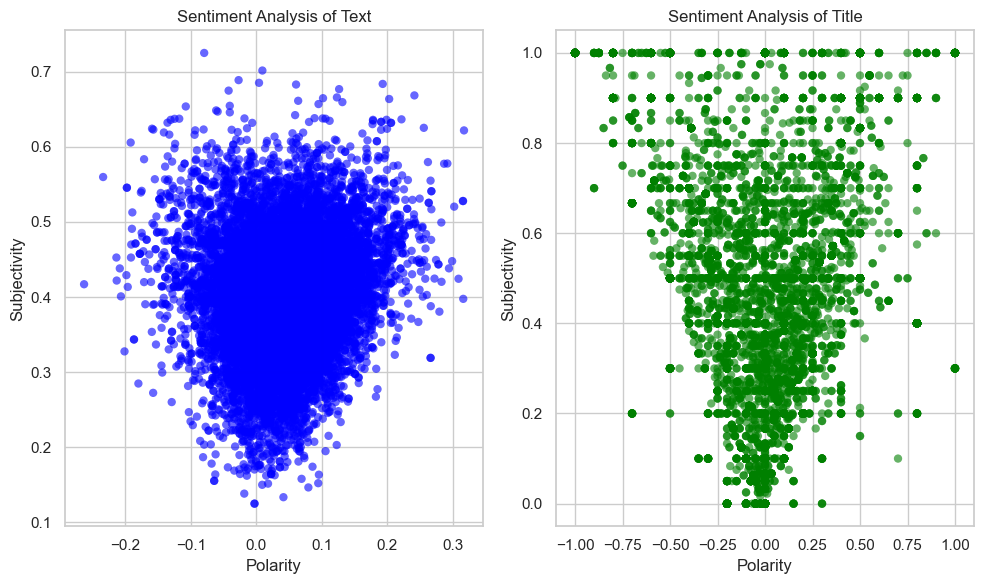

In [10]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a scatter plot for text sentiment
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.scatterplot(x='text_polarity', y='text_subjectivity', data=sentiment_df, alpha=0.6, edgecolor='none', color='blue')
plt.title('Sentiment Analysis of Text')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

# Create a scatter plot for title sentiment
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.scatterplot(x='title_polarity', y='title_subjectivity', data=sentiment_df, alpha=0.6, edgecolor='none', color='green')
plt.title('Sentiment Analysis of Title')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

To further deepen our understanding of the sentiment in the articles, we have further elaborated on the scatter plot, to enabling a distinction between fake and real news.

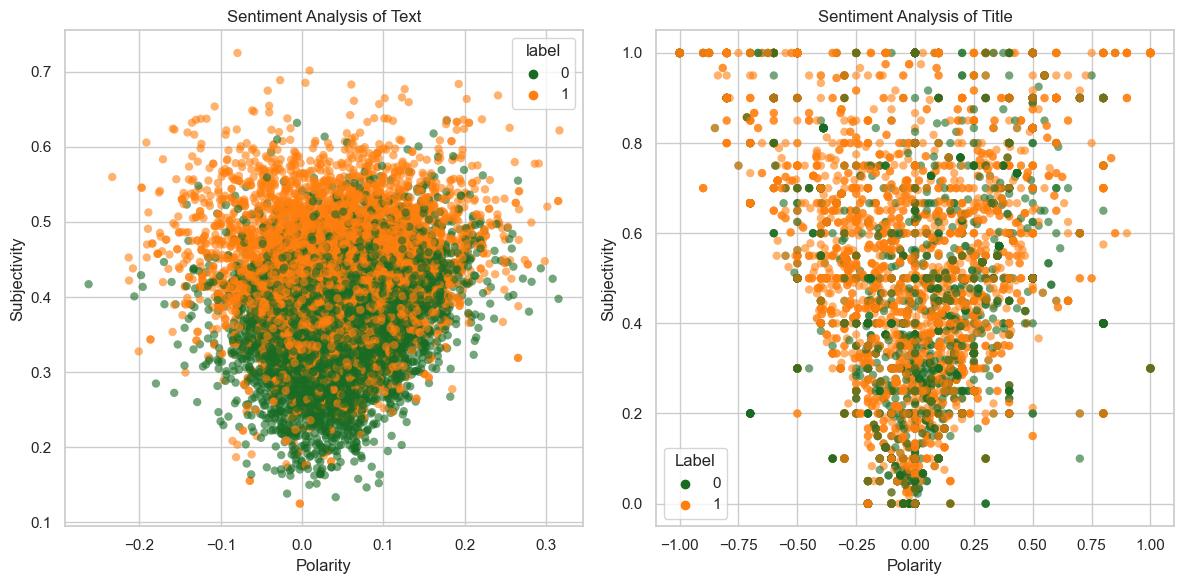

In [11]:
# Prepare the figure to host two plots
plt.figure(figsize=(12, 6))

custom_palette = ['#196B24', '#FF7F0E']  # Purple and blue

# Scatter plot for sentiment analysis of text
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.scatterplot(x='text_polarity', y='text_subjectivity', hue='label', data=sentiment_df, palette=custom_palette, alpha=0.6, edgecolor='none')
plt.title('Sentiment Analysis of Text')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

# Scatter plot for sentiment analysis of title
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.scatterplot(x='title_polarity', y='title_subjectivity', hue='label', data=sentiment_df, palette=custom_palette, alpha=0.6, edgecolor='none')
plt.title('Sentiment Analysis of Title')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

# Add a legend and show the plot
plt.legend(title='Label')
plt.tight_layout()
plt.show()

To further examine the results from above, we now vizualize the distribution of subjectivity scores between fake and real news by creating a density plot

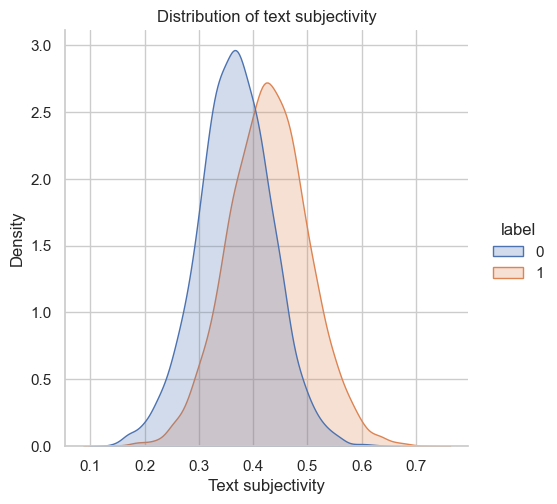

In [12]:
# label' is 0 for real news and 1 for fake news
sns.displot(sentiment_df, x="text_subjectivity", hue="label", kind="kde", fill=True)
plt.title('Distribution of text subjectivity')
plt.xlabel('Text subjectivity')
plt.ylabel('Density')
plt.show()

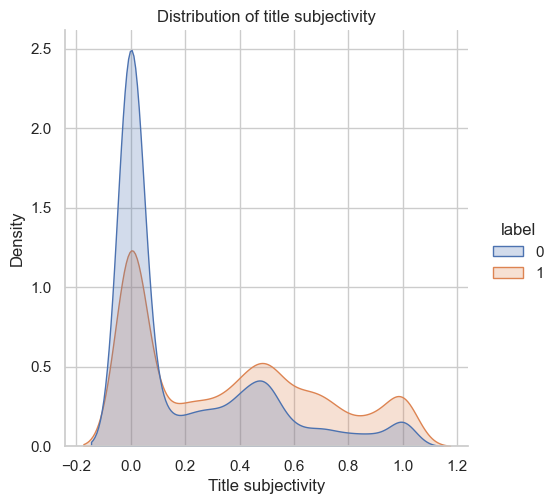

In [13]:
# label' is 0 for real news and 1 for fake news
sns.displot(sentiment_df, x="title_subjectivity", hue="label", kind="kde", fill=True)
plt.title('Distribution of title subjectivity')
plt.xlabel('Title subjectivity')
plt.ylabel('Density')
plt.show()

Below we create a correlation matrix and then correlation heatmaps to analyze whether hidden dependencies exits and to further deepen our analysis

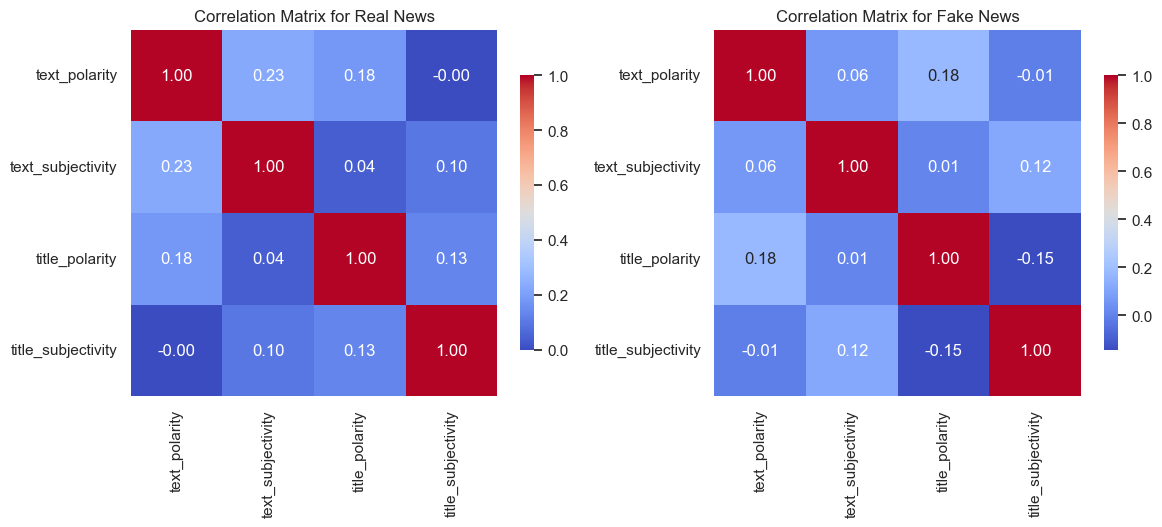

In [14]:
# Split the dataset into real and fake news
real_news = sentiment_df[sentiment_df['label'] == 0]  # 0 for real news
fake_news = sentiment_df[sentiment_df['label'] == 1]  # 1 for fake news

# Calculate correlation matrices
corr_matrix_real = real_news[['text_polarity', 'text_subjectivity', 'title_polarity', 'title_subjectivity']].corr()
corr_matrix_fake = fake_news[['text_polarity', 'text_subjectivity', 'title_polarity', 'title_subjectivity']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 5))

# Draw the heatmap for real news
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.heatmap(corr_matrix_real, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .75})
plt.title('Correlation Matrix for Real News')

# Draw the heatmap for fake news
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.heatmap(corr_matrix_fake, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .75})
plt.title('Correlation Matrix for Fake News')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Lastly, it is relevant to look into other factors that might affect the sentiment. As we work with news articles and thus a large corpus of text, we look at the relationship between the text length and the sentiment, to ensure that we examine all relevant aspects of the dataset.

In [15]:
# Calculate text length (word count)
sentiment_df['text_length'] = sentiment_df['cleaned_text'].apply(lambda x: len(x.split()))

# First few rows to verify
print(sentiment_df[['cleaned_text', 'text_length']].head())

                                        cleaned_text  text_length
0  donald trump met member nato go well moment ar...          218
1  washington reuters rick perry presidentelect d...          477
2  president obama blasted republican presidentia...          233
3  male idaho republican five daughter made creep...          343
4  kellyanne conway tried spin white house press ...          371


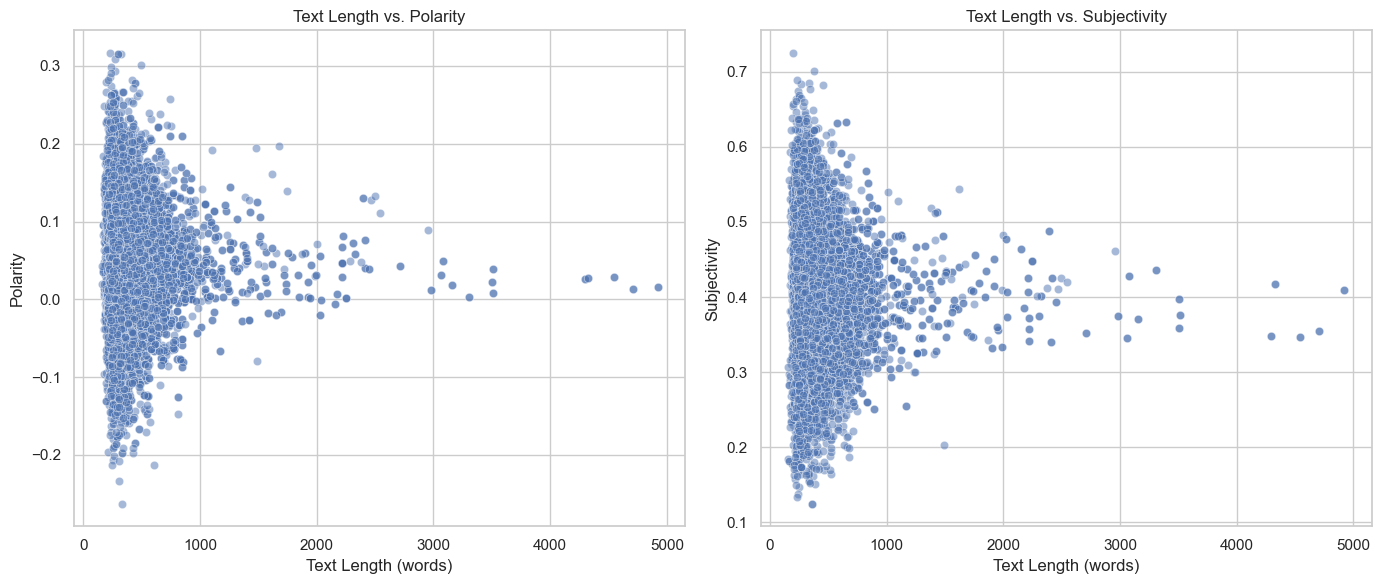

In [16]:
#Then we visualize the relationship between text length and sentiment
plt.figure(figsize=(14, 6))

# Scatter plot for Text Length vs. Polarity
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.scatterplot(x='text_length', y='text_polarity', data=sentiment_df, alpha=0.5)
plt.title('Text Length vs. Polarity')
plt.xlabel('Text Length (words)')
plt.ylabel('Polarity')

# Scatter plot for Text Length vs. Subjectivity
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.scatterplot(x='text_length', y='text_subjectivity', data=sentiment_df, alpha=0.5)
plt.title('Text Length vs. Subjectivity')
plt.xlabel('Text Length (words)')
plt.ylabel('Subjectivity')

# Show the plots
plt.tight_layout()
plt.show()

Due to the large amount of data, we also look at the relationship with a more statisitcal approach, to get a more detailed understanding of what is illustrated above in the scatter plot

In [17]:
# Calculate and print correlation coefficients
correlation_polarity = sentiment_df['text_length'].corr(sentiment_df['text_polarity'])
correlation_subjectivity = sentiment_df['text_length'].corr(sentiment_df['text_subjectivity'])

print("Correlation between Text Length and Polarity:", correlation_polarity)
print("Correlation between Text Length and Subjectivity:", correlation_subjectivity)

Correlation between Text Length and Polarity: -0.012886984838345545
Correlation between Text Length and Subjectivity: -0.026868316615728745


The results above show a very weak correlation, thus the text length does not have a large impact on the polarity or the subjectivity of the text.

### TTR ANALYSIS

In [18]:
# Downloading the necessary NLTK resource
nltk.download('punkt')

def calculate_ttr(text):
    if pd.isna(text):  # Check if the text is NaN
        return 0  # Return 0 or some predefined TTR value for NaN entries
    
    # Convert text to string in case it's not
    text = str(text).lower()

    # Tokenize the text
    tokens = word_tokenize(text)
    # Calculate number of unique words (types)
    types = len(set(tokens))
    # Calculate total number of words (tokens)
    tokens_count = len(tokens)
    # Calculate Type-Token Ratio (TTR)
    return types / tokens_count if tokens_count > 0 else 0  # Ensure no division by zero

# Loading DataFrame
ttr_df = pd.read_csv('text_dataset.csv')


# Apply the TTR calculation to the 'cleaned_text' column
ttr_df['TTR'] = ttr_df['cleaned_text'].apply(calculate_ttr)

# Print the first few rows of the DataFrame to see the TTR values
print(ttr_df[['cleaned_text', 'TTR']].head())

# Saving the TTR feature to the feature csv file
# ttr_df.to_csv('Updated_with_TTR.csv', index=False)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/claramillekalo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                        cleaned_text       TTR
0  donald trump met member nato go well moment ar...  0.844037
1  washington reuters rick perry presidentelect d...  0.683438
2  president obama blasted republican presidentia...  0.721030
3  male idaho republican five daughter made creep...  0.667638
4  kellyanne conway tried spin white house press ...  0.628032


In [19]:
max_ttr_index = ttr_df['TTR'].idxmax()

# Print the row with the highest TTR
print("Row with the highest TTR:")
print(ttr_df.loc[max_ttr_index])

Row with the highest TTR:
label                                                              1
cleaned_text       trump running confirmthere lot change end firs...
cleaned_subject                                             politics
cleaned_title      exclusive america 2021 hilarious poem describe...
token_count                                                       86
TTR                                                         0.896067
Name: 4578, dtype: object


Visualizing the TTR results

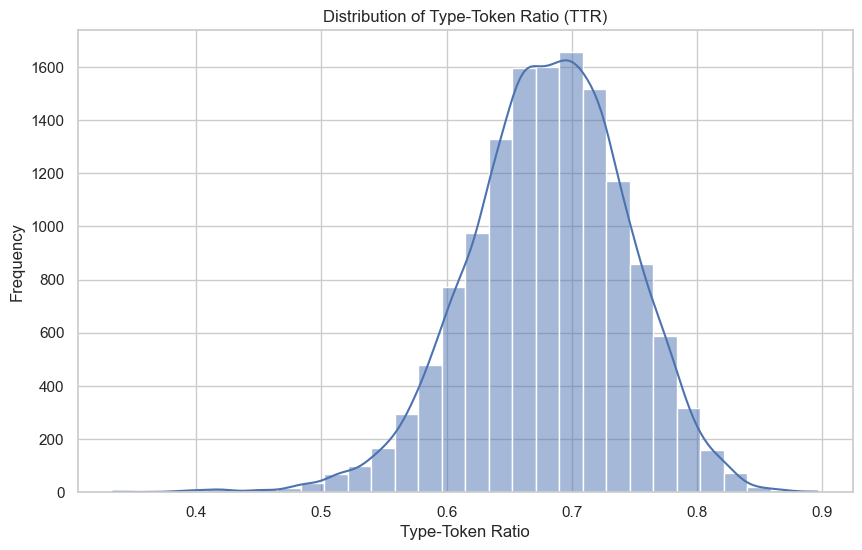

In [20]:
#Creating a histogram
# Plot a histogram of the TTR values
plt.figure(figsize=(10, 6))
sns.histplot(ttr_df['TTR'], kde=True, bins=30)  # kde adds a density plot
plt.title('Distribution of Type-Token Ratio (TTR)')
plt.xlabel('Type-Token Ratio')
plt.ylabel('Frequency')
plt.show()

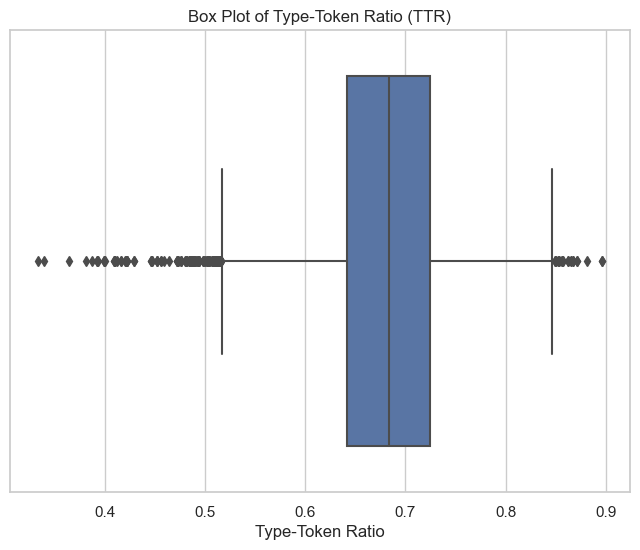

In [21]:
# Creating a Box plot

plt.figure(figsize=(8, 6))
sns.boxplot(x=ttr_df['TTR'])
plt.title('Box Plot of Type-Token Ratio (TTR)')
plt.xlabel('Type-Token Ratio')
plt.show()

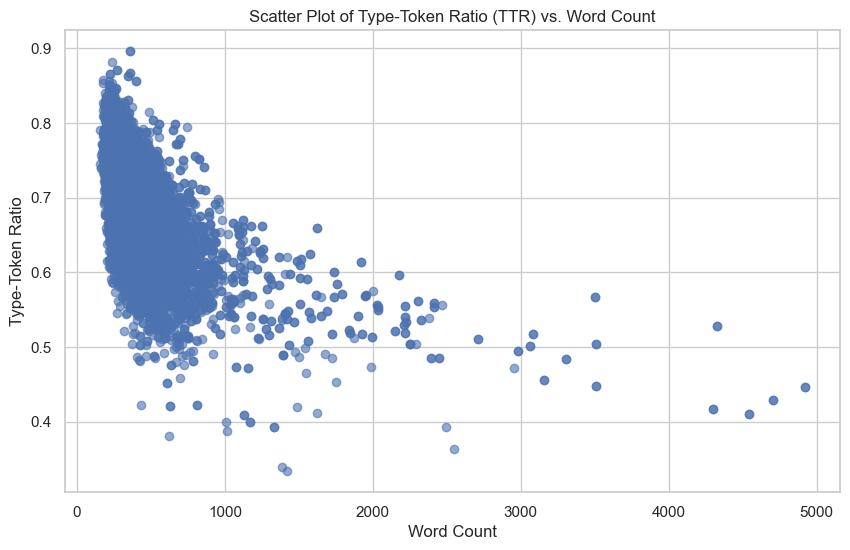

In [22]:
#Creating a Scatter Plot

# Plotting TTR against another variable 'WordCount'
ttr_df['WordCount'] = ttr_df['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.scatter(ttr_df['WordCount'], ttr_df['TTR'], alpha=0.6)
plt.title('Scatter Plot of Type-Token Ratio (TTR) vs. Word Count')
plt.xlabel('Word Count')
plt.ylabel('Type-Token Ratio')
plt.show()

### DOCUMENT PERPLEXITY

In [23]:
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel

# Ensure necessary NLTK resources are downloaded
nltk.download('punkt')

#Loading dataframe
perplexity_df = pd.read_csv('text_dataset.csv')

perplexity_df['tokenized_text'] = perplexity_df['cleaned_text'].apply(word_tokenize)

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(perplexity_df['tokenized_text'])
corpus = [dictionary.doc2bow(text) for text in perplexity_df['tokenized_text']]

# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=100,
                     update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

# Function to calculate a simplified document-level perplexity
def document_perplexity(lda_model, doc_bow):
    # Get topic probability distribution for the document
    doc_topics, word_topics, phi_values = lda_model.get_document_topics(doc_bow, per_word_topics=True)
    # Compute perplexity for the document (simplified version)
    doc_perplexity = np.exp(-np.mean([score for _, score in doc_topics]))
    return doc_perplexity

# Calculate document-level perplexity for each document in the corpus
perplexity_df['doc_perplexity'] = [document_perplexity(lda_model, corp) for corp in corpus]

# Save the updated DataFrame with the new 'doc_perplexity' feature
#perplexity_df.to_csv('Updated_with_Doc_Perplexity.csv', index=False)

# Print some of the updated DataFrame rows to check
print(perplexity_df[['cleaned_text', 'doc_perplexity']].head())

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/claramillekalo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                        cleaned_text  doc_perplexity
0  donald trump met member nato go well moment ar...        0.867938
1  washington reuters rick perry presidentelect d...        0.882860
2  president obama blasted republican presidentia...        0.883760
3  male idaho republican five daughter made creep...        0.882882
4  kellyanne conway tried spin white house press ...        0.883120


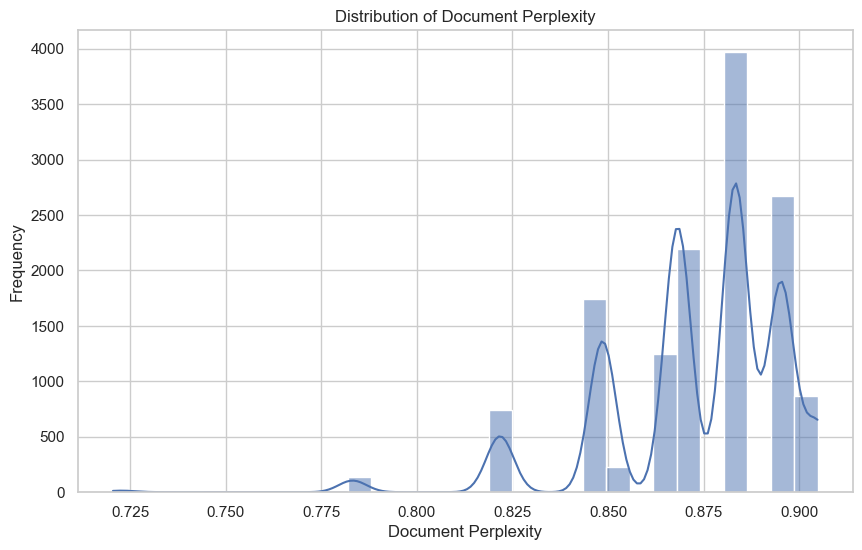

In [24]:
# Plot a histogram of the document perplexity
plt.figure(figsize=(10, 6))
sns.histplot(perplexity_df['doc_perplexity'], kde=True, bins=30)
plt.title('Distribution of Document Perplexity')
plt.xlabel('Document Perplexity')
plt.ylabel('Frequency')
plt.show()

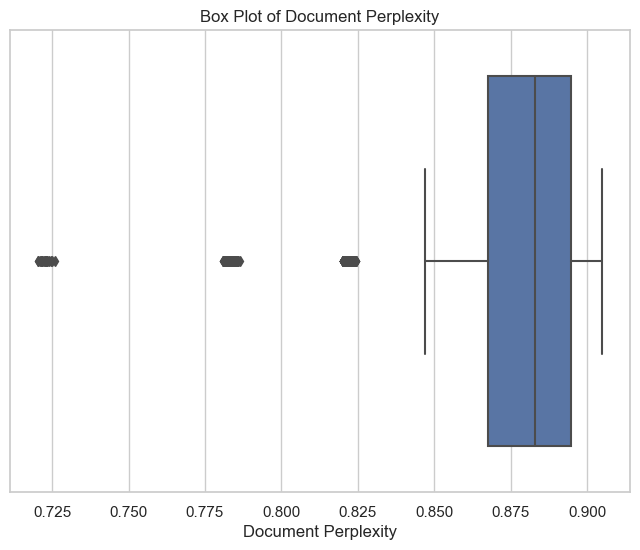

In [25]:
# Plot a box plot of document perplexity
plt.figure(figsize=(8, 6))
sns.boxplot(x=perplexity_df['doc_perplexity'])
plt.title('Box Plot of Document Perplexity')
plt.xlabel('Document Perplexity')
plt.show()

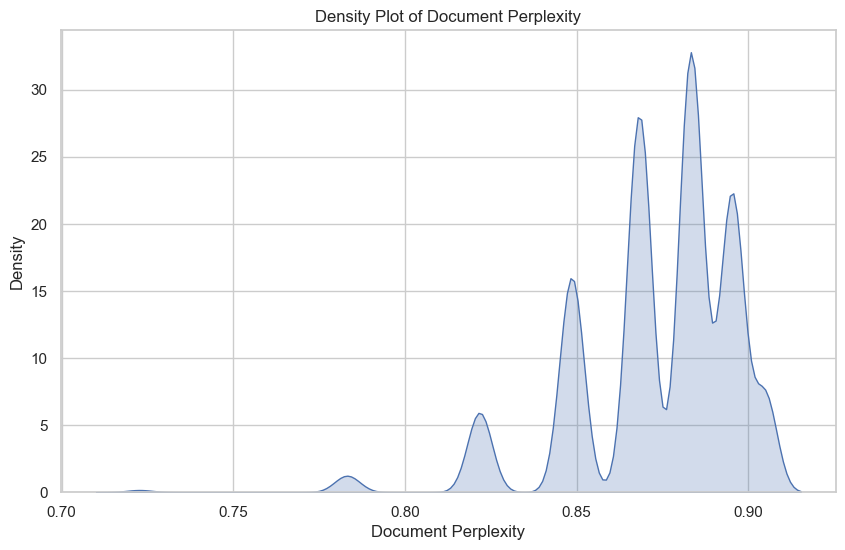

In [26]:
# Plot a density plot of document perplexity
plt.figure(figsize=(10, 6))
sns.kdeplot(perplexity_df['doc_perplexity'], fill=True)
plt.title('Density Plot of Document Perplexity')
plt.xlabel('Document Perplexity')
plt.ylabel('Density')
plt.show()

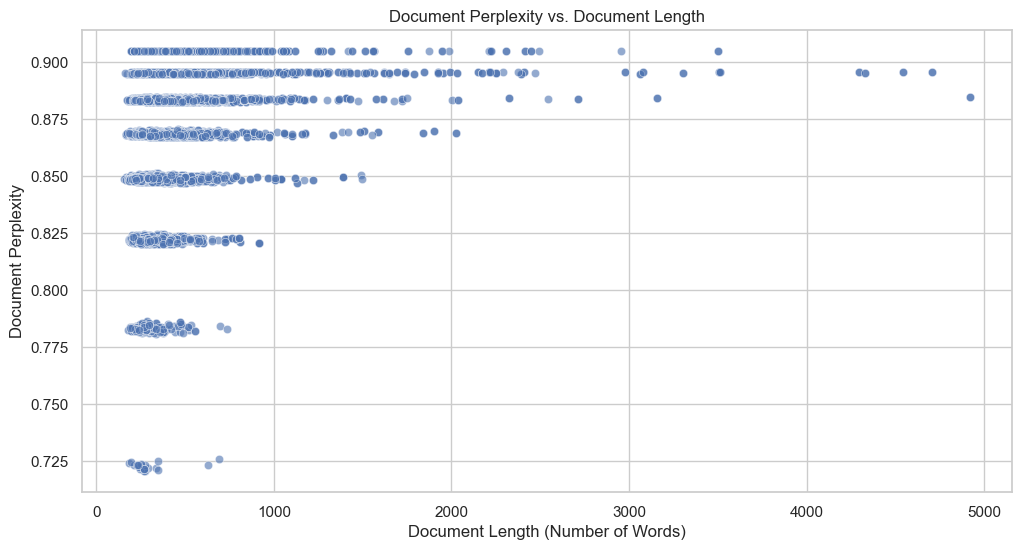

In [27]:
perplexity_df['document_length'] = perplexity_df['cleaned_text'].apply(lambda x: len(x.split()))

# Plotting
plt.figure(figsize=(12, 6))
sns.scatterplot(x='document_length', y='doc_perplexity', data=perplexity_df, alpha=0.6)
plt.title('Document Perplexity vs. Document Length')
plt.xlabel('Document Length (Number of Words)')
plt.ylabel('Document Perplexity')
plt.show()

### N-grams


In [32]:
# Read data from CSV
ngram_df = pd.read_csv('text_dataset.csv')

# Function to generate n-grams
def generate_ngrams(text, n):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngrams = vectorizer.build_analyzer()(text)
    return ngrams

# Generate n-grams for each text in the dataframe for n = 1 to 6
for n in range(1, 7):
    ngram_df[f'{n}_grams'] = ngram_df['cleaned_text'].apply(lambda x: generate_ngrams(x, n))


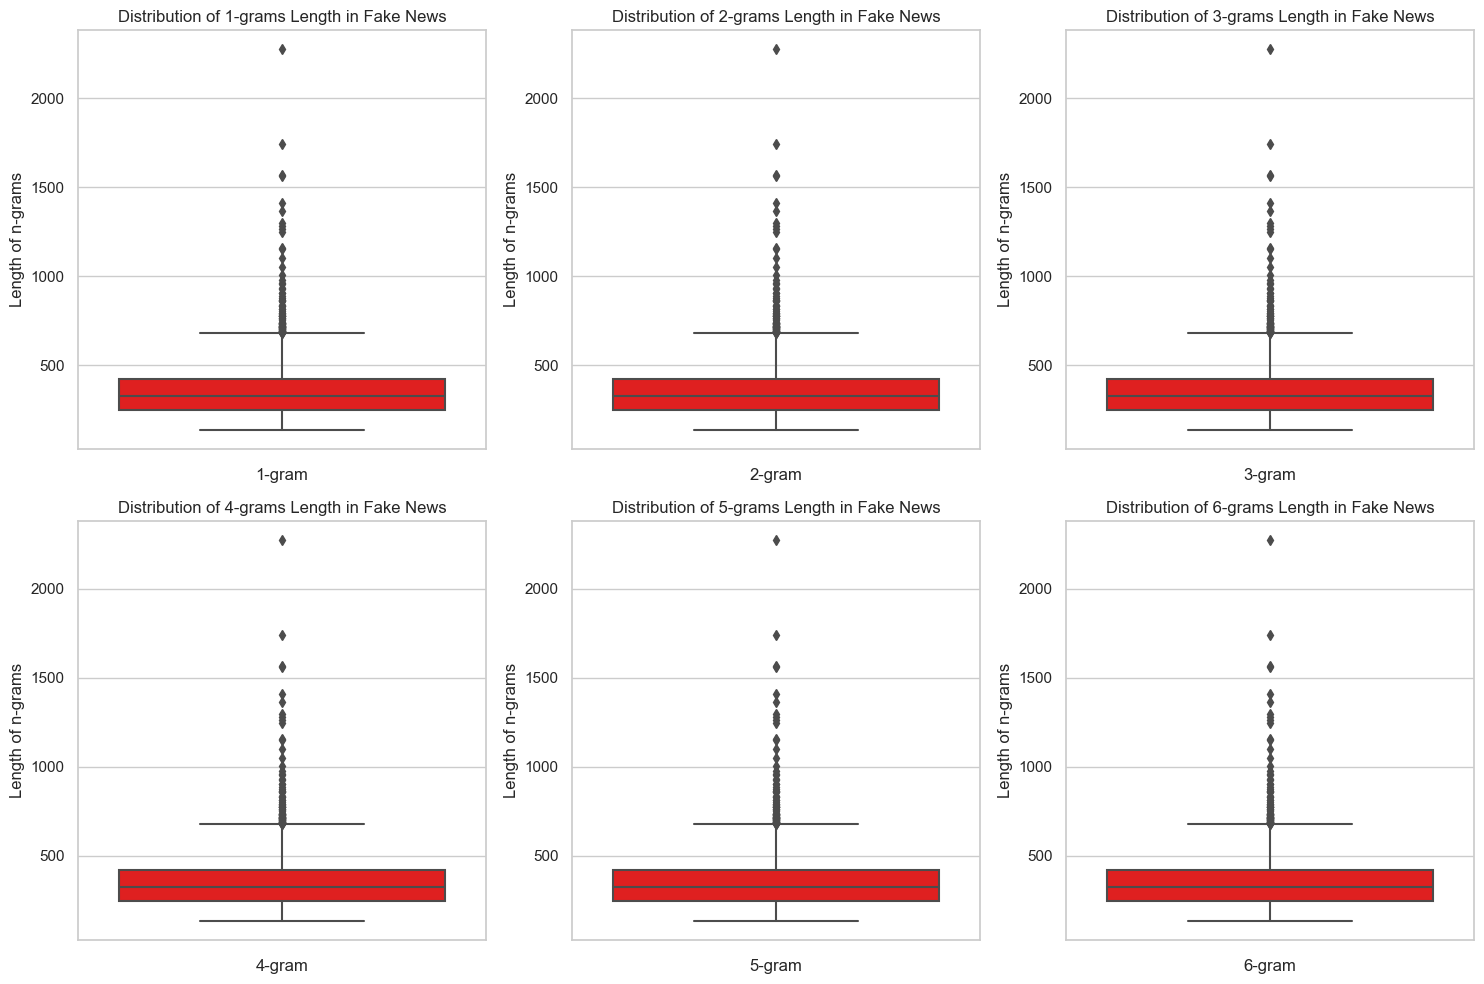

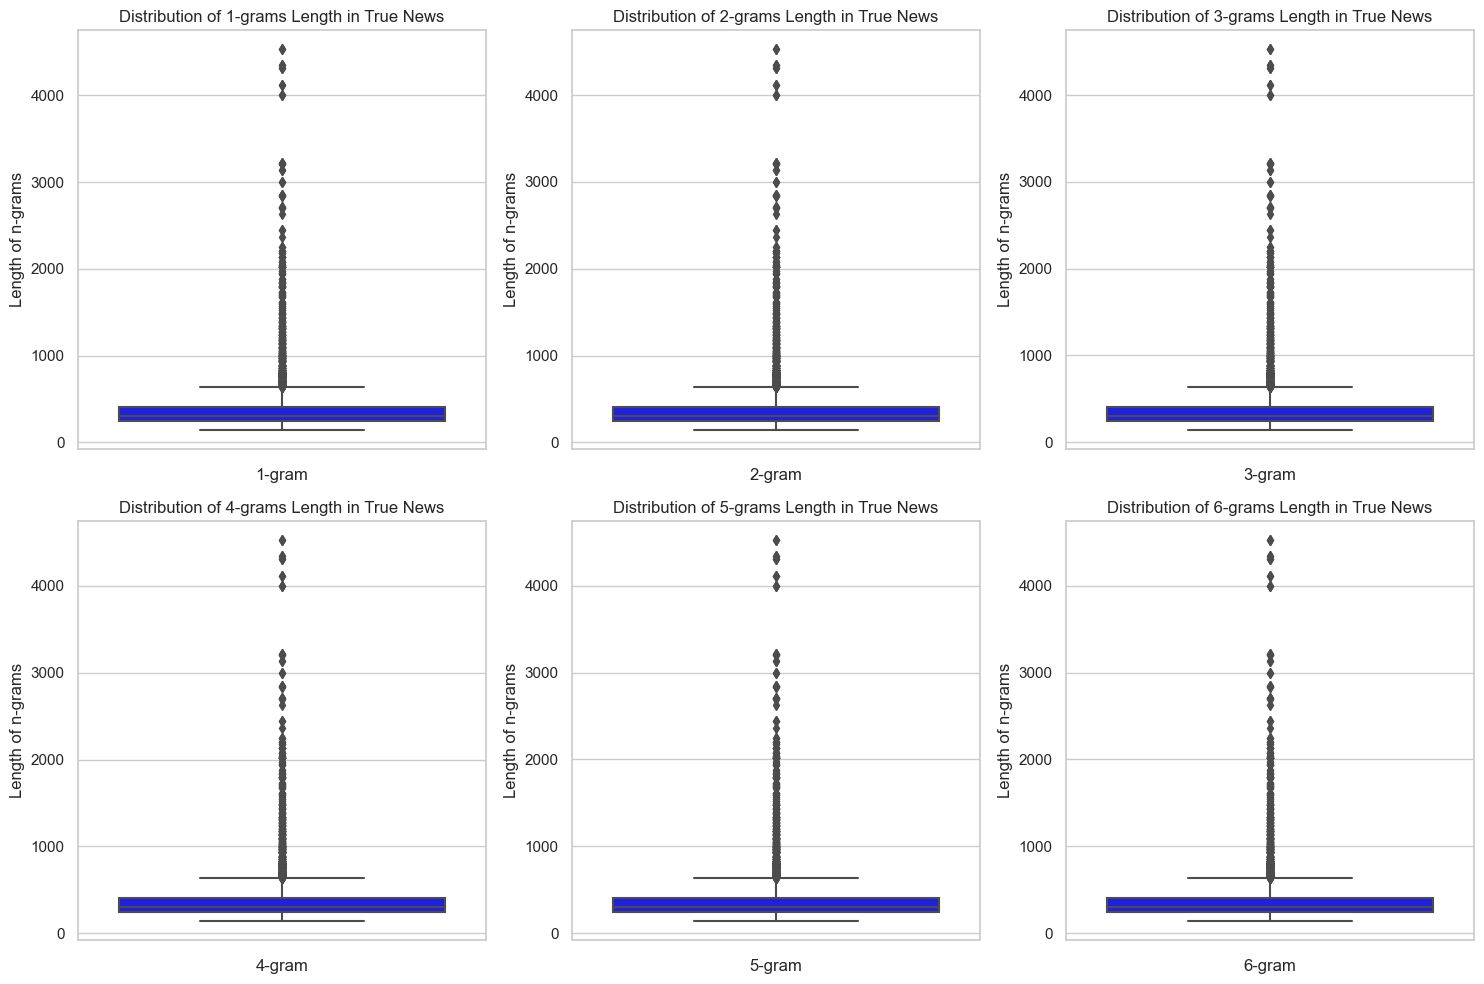

In [33]:
# Plot boxplots for each n-gram range for fake news
plt.figure(figsize=(15, 10))
for n in range(1, 7):
    plt.subplot(2, 3, n)
    sns.boxplot(y=ngram_df[ngram_df['label'] == 0][f'{n}_grams'].apply(lambda x: len(x)), color='red')
    plt.xlabel(f'{n}-gram')
    plt.ylabel('Length of n-grams')
    plt.title(f'Distribution of {n}-grams Length in Fake News')

plt.tight_layout()
plt.show()

# Plot boxplots for each n-gram range for true news
plt.figure(figsize=(15, 10))
for n in range(1, 7):
    plt.subplot(2, 3, n)
    sns.boxplot(y=ngram_df[ngram_df['label'] == 1][f'{n}_grams'].apply(lambda x: len(x)), color='blue')
    plt.xlabel(f'{n}-gram')
    plt.ylabel('Length of n-grams')
    plt.title(f'Distribution of {n}-grams Length in True News')

plt.tight_layout()
plt.show()


In [36]:
ngram_df

,label,cleaned_text,cleaned_subject,cleaned_title,token_count,1_grams,2_grams,3_grams,4_grams,5_grams,6_grams
0,1,donald trump met member nato go well moment ar...,news,watch trump shove foreign leader way get front...,71,"[donald, trump, met, member, nato, moment, arr...","[donald trump, trump met, met member, member n...","[donald trump met, trump met member, met membe...","[donald trump met member, trump met member nat...","[donald trump met member nato, trump met membe...","[donald trump met member nato moment, trump me..."
1,0,washington reuters rick perry presidentelect d...,politicsnews,trump energy pick perry softens stance climate...,128,"[washington, reuters, rick, perry, presidentel...","[washington reuters, reuters rick, rick perry,...","[washington reuters rick, reuters rick perry, ...","[washington reuters rick perry, reuters rick p...","[washington reuters rick perry presidentelect,...",[washington reuters rick perry presidentelect ...
2,1,president obama blasted republican presidentia...,politics,obama finally build border wallbut there one p...,81,"[president, obama, blasted, republican, presid...","[president obama, obama blasted, blasted repub...","[president obama blasted, obama blasted republ...","[president obama blasted republican, obama bla...",[president obama blasted republican presidenti...,[president obama blasted republican presidenti...
3,1,male idaho republican five daughter made creep...,news,republican lawmaker say rape wont cause pregna...,82,"[male, idaho, republican, daughter, creepy, ou...","[male idaho, idaho republican, republican daug...","[male idaho republican, idaho republican daugh...","[male idaho republican daughter, idaho republi...","[male idaho republican daughter creepy, idaho ...",[male idaho republican daughter creepy outrage...
4,1,kellyanne conway tried spin white house press ...,news,watch chuck todd swat annoying kellyanne conwa...,75,"[kellyanne, conway, tried, spin, white, house,...","[kellyanne conway, conway tried, tried spin, s...","[kellyanne conway tried, conway tried spin, tr...","[kellyanne conway tried spin, conway tried spi...","[kellyanne conway tried spin white, conway tri...","[kellyanne conway tried spin white house, conw..."
...,...,...,...,...,...,...,...,...,...,...,...
13829,0,washington reuters member u congress party fri...,politicsnews,u lawmaker back syria strike demand plan trump,107,"[washington, reuters, member, congress, party,...","[washington reuters, reuters member, member co...","[washington reuters member, reuters member con...","[washington reuters member congress, reuters m...","[washington reuters member congress party, reu...",[washington reuters member congress party frid...
13830,1,far video 530000 view make content legitimate ...,politics,ups secretly fly refugee u middle east watch g...,110,"[far, video, 530000, view, make, content, legi...","[far video, video 530000, 530000 view, view ma...","[far video 530000, video 530000 view, 530000 v...","[far video 530000 view, video 530000 view make...","[far video 530000 view make, video 530000 view...","[far video 530000 view make content, video 530..."
13831,0,dec 27 story corrects say 55000 page email ins...,politicsnews,u appeal court revives clinton email suit,82,"[dec, 27, story, corrects, say, 55000, page, e...","[dec 27, 27 story, story corrects, corrects sa...","[dec 27 story, 27 story corrects, story correc...","[dec 27 story corrects, 27 story corrects say,...","[dec 27 story corrects say, 27 story corrects ...","[dec 27 story corrects say 55000, 27 story cor..."
13832,0,madrid reuters spain high court said tuesday g...,worldnews,spanish court grant u extradition russian hack...,75,"[madrid, reuters, spain, high, court, said, tu...","[madrid reuters, reuters spain, spain high, hi...","[madrid reuters spain, reuters spain high, spa...","[madrid reuters spain high, reuters spain high...","[madrid reuters spain high court, reuters spai...","[madrid reuters spain high court said, reu

Comparing the n-grams

In [34]:
# Initialize logistic regression model
lr_model = LogisticRegression(max_iter=1000)

# Compare the performance of logistic regression models for each n-gram range using cross-validation
results = {}
for n in range(1, 7):
    X = ngram_df[f'{n}_grams']
    y = ngram_df['label']
    
    # Convert the list of strings to a single string before passing it to CountVectorizer
    X_transformed = CountVectorizer().fit_transform([' '.join(doc) for doc in X])
    
    scores = cross_val_score(lr_model, X_transformed, y, cv=5)
    results[n] = np.mean(scores)

# Print the results
for n, score in results.items():
    print(f'{n}-gram: {score}')

# Find the best n-gram
best_ngram = max(results, key=results.get)
print(f'Best n-gram: {best_ngram}')

1-gram: 0.992843765262581
2-gram: 0.9915424820102432
3-gram: 0.9902414600755052
4-gram: 0.9887956943221695
5-gram: 0.9874222612804928
6-gram: 0.9866271240874462
Best n-gram: 1


As seen fromt the results above, the performance is the best with 1-gram, thus we exclude the other grams

In [37]:
columns_to_drop = ['label','cleaned_text', 'cleaned_subject', 'token_count', 'cleaned_title', '2_grams','3_grams', '4_grams', '5_grams','6_grams']
ngram_df.drop(columns_to_drop, axis=1, inplace=True)
ngram_df


,1_grams
0,"[donald, trump, met, member, nato, moment, arr..."
1,"[washington, reuters, rick, perry, presidentel..."
2,"[president, obama, blasted, republican, presid..."
3,"[male, idaho, republican, daughter, creepy, ou..."
4,"[kellyanne, conway, tried, spin, white, house,..."
...,...
13829,"[washington, reuters, member, congress, party,..."
13830,"[far, video, 530000, view, make, content, legi..."
13831,"[dec, 27, story, corrects, say, 55000, page, e..."
13832,"[madrid, reuters, spain, high, court, said, tu..."


### Now we combine all the features into a dataframe, to create a single dataset consisting of all features

First, we drop all other columns in the dataframe besides the coloumns containing the feature value for each feature

In [40]:
#Dropping average word lenght columns
columns_to_drop_avg = ['label','cleaned_text', 'cleaned_subject', 'token_count', 'cleaned_title']
avg_word_length_df.drop(columns_to_drop_avg, axis=1, inplace=True)
avg_word_length_df

,average_word_length
0,6.490826
1,6.385744
2,6.072961
3,6.469388
4,6.296496
...,...
13829,6.514512
13830,6.782524
13831,6.117021
13832,6.478632


In [44]:
#Dropping sentiment analysis columns
columns_to_drop_sentiment = ['label','cleaned_text', 'cleaned_subject', 'token_count', 'cleaned_title']
sentiment_df.drop(columns_to_drop_sentiment, axis=1, inplace=True)
sentiment_df

,text_polarity,text_subjectivity,title_polarity,title_subjectivity
0,0.091481,0.524184,-0.125000,0.125000
1,0.003001,0.343395,0.000000,0.000000
2,0.073622,0.401345,0.000000,1.000000
3,0.037264,0.462935,0.000000,1.000000
4,-0.018966,0.479310,-0.800000,0.900000
...,...,...,...,...
13829,-0.030698,0.380595,0.000000,0.000000
13830,-0.009035,0.312617,-0.066667,0.633333
13831,0.049287,0.244648,0.000000,0.000000
13832,-0.026939,0.293520,0.000000,0.000000


In [49]:
#Dropping TTR columns
columns_to_drop_ttr = ['WordCount']
ttr_df.drop(columns_to_drop_ttr, axis=1, inplace=True)
ttr_df

,TTR
0,0.844037
1,0.683438
2,0.721030
3,0.667638
4,0.628032
...,...
13829,0.659631
13830,0.629126
13831,0.595745
13832,0.696581


In [48]:
#Dropping Perplexity columns
columns_to_drop_perp = ['tokenized_text', 'document_length']
perplexity_df.drop(columns_to_drop_perp, axis=1, inplace=True)
perplexity_df


,doc_perplexity
0,0.867938
1,0.882860
2,0.883760
3,0.882882
4,0.883120
...,...
13829,0.882810
13830,0.895444
13831,0.883645
13832,0.895276


### Now we combine the clean dataframes into on big dataframe, that will be the feature dataset

In [51]:
# Load your existing text dataset
text_dataset = pd.read_csv("text_dataset.csv")

# Now we concatenate all the feature dataframes along the columns
features_dataset = pd.concat([text_dataset['label'], ttr_df, sentiment_df, perplexity_df, ngram_df, avg_word_length_df], axis=1)

# Print the features dataset to a CSV file
features_dataset.to_csv("features_dataset.csv", index=False)


In [52]:
features_dataset

,label,TTR,text_polarity,text_subjectivity,title_polarity,title_subjectivity,doc_perplexity,1_grams,average_word_length
0,1,0.844037,0.091481,0.524184,-0.125000,0.125000,0.867938,"[donald, trump, met, member, nato, moment, arr...",6.490826
1,0,0.683438,0.003001,0.343395,0.000000,0.000000,0.882860,"[washington, reuters, rick, perry, presidentel...",6.385744
2,1,0.721030,0.073622,0.401345,0.000000,1.000000,0.883760,"[president, obama, blasted, republican, presid...",6.072961
3,1,0.667638,0.037264,0.462935,0.000000,1.000000,0.882882,"[male, idaho, republican, daughter, creepy, ou...",6.469388
4,1,0.628032,-0.018966,0.479310,-0.800000,0.900000,0.883120,"[kellyanne, conway, tried, spin, white, house,...",6.296496
...,...,...,...,...,...,...,...,...,...
13829,0,0.659631,-0.030698,0.380595,0.000000,0.000000,0.882810,"[washington, reuters, member, congress, party,...",6.514512
13830,1,0.629126,-0.009035,0.312617,-0.066667,0.633333,0.895444,"[far, video, 530000, view, make, content, legi...",6.782524
13831,0,0.595745,0.049287,0.244648,0.000000,0.000000,0.883645,"[dec, 27, story, corrects, say, 55000, page, e...",6.117021
13832,0,0.696581,-0.026939,0.293520,0.000000,0.000000,0.895276,"[madrid, reuters, spain, high, court, said, tu...",6.478632
